In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import json
from os.path import expanduser

In [66]:
PROTON_MASS = 1.00727647
ADD_C_CYSTEINE_DA = 57.021464

In [67]:
# calculate the monoisotopic mass    
def calculate_monoisotopic_mass_from_mz(monoisotopic_mz, charge):
    monoisotopic_mass = (monoisotopic_mz * charge) - (PROTON_MASS * charge)
    return monoisotopic_mass

In [68]:
experiment_name = 'P3830'
run_name = 'P3830_YeastUPS2_01_Slot1-1_1_5082'
experiment_base_dir = '/media/big-ssd/experiments'

In [69]:
EXPERIMENT_DIR = "{}/{}".format(experiment_base_dir, experiment_name)
MQ_PERCOLATOR_OUTPUT_DIR = '{}/percolator-output-maxquant'.format(EXPERIMENT_DIR)
MQ_MGF_DIR = '{}/mgf-maxquant'.format(EXPERIMENT_DIR)

In [70]:
MAXIMUM_Q_VALUE = 0.01

In [71]:
# load the percolator output
MQ_PERCOLATOR_OUTPUT_FILE_NAME = "{}/{}.percolator.target.psms.txt".format(MQ_PERCOLATOR_OUTPUT_DIR, experiment_name)
mq_psms_df = pd.read_csv(MQ_PERCOLATOR_OUTPUT_FILE_NAME, sep='\t')
mq_psms_df.rename(columns={'scan': 'mq_index'}, inplace=True)
mq_psms_df.drop(['charge'], axis=1, inplace=True)
# remove the poor quality identifications
mq_psms_df = mq_psms_df[mq_psms_df['peptide mass'] > 0]

In [72]:
PERCOLATOR_STDOUT_FILE_NAME = "{}/P3830.percolator.log.txt".format(MQ_PERCOLATOR_OUTPUT_DIR)

In [73]:
# determine the mapping between the percolator index and the run file name - this is only available by parsing percolator's stdout redirected to a text file.
mapping = []
with open(PERCOLATOR_STDOUT_FILE_NAME) as f:
    lines = f.readlines()
    for line in lines:
        if line.startswith('INFO: Assigning index'):
            splits = line.split(' ')
            percolator_index = int(splits[3])
            comet_filename = splits[5]
            rn = comet_filename.split('/')[-1].split('.')[0]  # e.g. 190719_Hela_Ecoli_1to3_06
            mapping.append((percolator_index, run_name))
mapping_df = pd.DataFrame(mapping, columns=['file_idx','run_name'])

In [74]:
mapping_df

,file_idx,run_name
0,0,P3830_YeastUPS2_01_Slot1-1_1_5082
1,1,P3830_YeastUPS2_01_Slot1-1_1_5082


In [75]:
# add the run names
mq_percolator_df = pd.merge(mq_psms_df, mapping_df, how='left', left_on=['file_idx'], right_on=['file_idx'])

In [76]:
mq_percolator_df.run_name.unique()

array(['P3830_YeastUPS2_01_Slot1-1_1_5082'], dtype=object)

In [77]:
# merge the precolator results with the MQ features - obtained with the -v flag of the APL-to-MGF converter (generate-MGF-from-MaxQuant-APLs.py)
MQ_FEATURES_NAME = '{}/{}.pkl'.format(MQ_MGF_DIR, run_name)
mq_features_df = pd.read_pickle(MQ_FEATURES_NAME)

In [78]:
MQ_FEATURES_NAME

'/media/big-ssd/experiments/P3830/mgf-maxquant/P3830_YeastUPS2_01_Slot1-1_1_5082.pkl'

In [79]:
run_name

'P3830_YeastUPS2_01_Slot1-1_1_5082'

In [80]:
mq_features_df.columns

Index(['monoisotopic_mass', 'charge', 'monoisotopic_mz', 'intensity',
       'scan_apex', 'rt_apex', 'raw_file', 'mq_index', 'ms2_peaks'],
      dtype='object')

In [81]:
mq_features_df.raw_file.unique()

array(['P3830_YeastUPS2_01_Slot1-1_1_5082'], dtype=object)

In [82]:
mq_identifications_df = pd.merge(mq_features_df, mq_percolator_df, how='left', left_on=['raw_file','mq_index'], right_on=['run_name','mq_index'])
# remove any features that were not identified
mq_identifications_df.dropna(subset=['sequence'], inplace=True)


In [83]:
mq_identifications_df['theoretical_peptide_mass'] = mq_identifications_df['peptide mass'] + (mq_identifications_df.sequence.str.count('C') * ADD_C_CYSTEINE_DA)
mq_identifications_df['mass_accuracy_ppm'] = (mq_identifications_df['monoisotopic_mass'] - mq_identifications_df['theoretical_peptide_mass']) / mq_identifications_df['theoretical_peptide_mass'] * 10**6
mq_identifications_df['mass_error'] = mq_identifications_df['monoisotopic_mass'] - mq_identifications_df['theoretical_peptide_mass']


In [84]:
mq_identifications_df.columns

Index(['monoisotopic_mass', 'charge', 'monoisotopic_mz', 'intensity',
       'scan_apex', 'rt_apex', 'raw_file', 'mq_index', 'ms2_peaks', 'file_idx',
       'spectrum precursor m/z', 'spectrum neutral mass', 'peptide mass',
       'percolator score', 'percolator q-value', 'percolator PEP',
       'total matches/spectrum', 'sequence', 'protein id', 'flanking aa',
       'run_name', 'theoretical_peptide_mass', 'mass_accuracy_ppm',
       'mass_error'],
      dtype='object')

In [85]:
mq_identifications_df = mq_identifications_df[(mq_identifications_df['percolator q-value'] <= MAXIMUM_Q_VALUE) & (~mq_identifications_df['protein id'].str.contains('YEAST'))]

In [86]:
mq_identifications_df.run_name.unique()

array(['P3830_YeastUPS2_01_Slot1-1_1_5082'], dtype=object)

In [87]:
print('number of unique proteins: {}'.format(len(mq_identifications_df['protein id'].unique())))

number of unique proteins: 46


#### using the Top3 approach to determine protein quanitification

In [88]:
ups2_proteins_l = []

ups2_proteins_l.append({'uniprot':'P00915', 'fmoles':50000})
ups2_proteins_l.append({'uniprot':'P00918', 'fmoles':50000})
ups2_proteins_l.append({'uniprot':'P01031', 'fmoles':50000})
ups2_proteins_l.append({'uniprot':'P69905', 'fmoles':50000})
ups2_proteins_l.append({'uniprot':'P68871', 'fmoles':50000})
ups2_proteins_l.append({'uniprot':'P41159', 'fmoles':50000})
ups2_proteins_l.append({'uniprot':'P02768', 'fmoles':50000})
ups2_proteins_l.append({'uniprot':'P62988', 'fmoles':50000})

ups2_proteins_l.append({'uniprot':'P04040', 'fmoles':5000})
ups2_proteins_l.append({'uniprot':'P00167', 'fmoles':5000})
ups2_proteins_l.append({'uniprot':'P01133', 'fmoles':5000})
ups2_proteins_l.append({'uniprot':'P02144', 'fmoles':5000})
ups2_proteins_l.append({'uniprot':'P15559', 'fmoles':5000})
ups2_proteins_l.append({'uniprot':'P62937', 'fmoles':5000})
ups2_proteins_l.append({'uniprot':'Q06830', 'fmoles':5000})
ups2_proteins_l.append({'uniprot':'P63165', 'fmoles':5000})

ups2_proteins_l.append({'uniprot':'P00709', 'fmoles':500})
ups2_proteins_l.append({'uniprot':'P06732', 'fmoles':500})
ups2_proteins_l.append({'uniprot':'P12081', 'fmoles':500})
ups2_proteins_l.append({'uniprot':'P61626', 'fmoles':500})
ups2_proteins_l.append({'uniprot':'Q15843', 'fmoles':500})
ups2_proteins_l.append({'uniprot':'P02753', 'fmoles':500})
ups2_proteins_l.append({'uniprot':'P16083', 'fmoles':500})
ups2_proteins_l.append({'uniprot':'P63279', 'fmoles':500})

ups2_proteins_l.append({'uniprot':'P01008', 'fmoles':50})
ups2_proteins_l.append({'uniprot':'P61769', 'fmoles':50})
ups2_proteins_l.append({'uniprot':'P55957', 'fmoles':50})
ups2_proteins_l.append({'uniprot':'O76070', 'fmoles':50})
ups2_proteins_l.append({'uniprot':'P08263', 'fmoles':50})
ups2_proteins_l.append({'uniprot':'P01344', 'fmoles':50})
ups2_proteins_l.append({'uniprot':'P01127', 'fmoles':50})
ups2_proteins_l.append({'uniprot':'P10599', 'fmoles':50})

ups2_proteins_l.append({'uniprot':'P99999', 'fmoles':5})
ups2_proteins_l.append({'uniprot':'P06396', 'fmoles':5})
ups2_proteins_l.append({'uniprot':'P09211', 'fmoles':5})
ups2_proteins_l.append({'uniprot':'P01112', 'fmoles':5})
ups2_proteins_l.append({'uniprot':'P01579', 'fmoles':5})
ups2_proteins_l.append({'uniprot':'P02787', 'fmoles':5})
ups2_proteins_l.append({'uniprot':'O00762', 'fmoles':5})
ups2_proteins_l.append({'uniprot':'P51965', 'fmoles':5})

ups2_proteins_l.append({'uniprot':'P08758', 'fmoles':0.5})
ups2_proteins_l.append({'uniprot':'P02741', 'fmoles':0.5})
ups2_proteins_l.append({'uniprot':'P05413', 'fmoles':0.5})
ups2_proteins_l.append({'uniprot':'P10145', 'fmoles':0.5})
ups2_proteins_l.append({'uniprot':'P02788', 'fmoles':0.5})
ups2_proteins_l.append({'uniprot':'P10636-8', 'fmoles':0.5})
ups2_proteins_l.append({'uniprot':'P00441', 'fmoles':0.5})
ups2_proteins_l.append({'uniprot':'P01375', 'fmoles':0.5})

ups2_d = {}
for p in ups2_proteins_l:
    ups2_d[p['uniprot']] = p['fmoles']

In [89]:
mq_identifications_df['protein id'].unique()

array(['P02768ups|ALBU_HUMAN_UPS', 'P00918ups|CAH2_HUMAN_UPS',
       'P02787ups|TRFE_HUMAN_UPS', 'P06732ups|KCRM_HUMAN_UPS',
       'P15559ups|NQO1_HUMAN_UPS', 'P00709ups|LALBA_HUMAN_UPS',
       'P10145ups|IL8_HUMAN_UPS', 'P68871ups|HBB_HUMAN_UPS',
       'P41159ups|LEP_HUMAN_UPS', 'P63165ups|SUMO1_HUMAN_UPS',
       'P02788ups|TRFL_HUMAN_UPS', 'P62937ups|PPIA_HUMAN_UPS',
       'P08758ups|ANXA5_HUMAN_UPS', 'P99999ups|CYC_HUMAN_UPS',
       'P00915ups|CAH1_HUMAN_UPS', 'P55957ups|BID_HUMAN_UPS',
       'P05413ups|FABPH_HUMAN_UPS', 'P01579ups|IFNG_HUMAN_UPS',
       'P00441ups|SODC_HUMAN_UPS', 'P06396ups|GELS_HUMAN_UPS',
       'P02753ups|RETBP_HUMAN_UPS', 'P04040ups|CATA_HUMAN_UPS',
       'P01008ups|ANT3_HUMAN_UPS', 'P02144ups|MYG_HUMAN_UPS',
       'P16083ups|NQO2_HUMAN_UPS', 'P09211ups|GSTP1_HUMAN_UPS',
       'P12081ups|SYHC_HUMAN_UPS', 'O76070ups|SYUG_HUMAN_UPS',
       'P01112ups|RASH_HUMAN_UPS', 'P00167ups|CYB5_HUMAN_UPS',
       'Q15843ups|NEDD8_HUMAN_UPS', 'P69905ups|HBA_HUMA

In [90]:
# find the three most intense peptides for each protein
top3_l = []
for group_name,group_df in mq_identifications_df.groupby('protein id'):
    df = group_df.sort_values(by=['intensity'], ascending=False, inplace=False)
    top3_df = df.head(n=3)
    if len(top3_df) == 3:
        uniprot_id = group_name.split('ups')[0]
        pmoles = ups2_d[uniprot_id] / 1000
        average_intensity = top3_df.intensity.mean()
        signal_response_factor = average_intensity / pmoles
        peptide_count = len(df)
        attribs_d = top3_df[['mq_index','sequence','charge','intensity']].to_dict('records')
        top3_l.append({'protein':group_name, 'pmoles':pmoles, 'average_intensity':average_intensity, 'signal_response_factor':signal_response_factor, 'peptide_count':peptide_count, 'attribs_d':attribs_d})
    else:
        print('didn\'t have three peptides for {}'.format(group_name))
mq_top3_df = pd.DataFrame(top3_l)

didn't have three peptides for O00762ups|UBE2C_HUMAN_UPS
didn't have three peptides for P01127ups|PDGFB_HUMAN_UPS
didn't have three peptides for P01133ups|EGF_HUMAN_UPS
didn't have three peptides for P01344ups|IGF2_HUMAN_UPS
didn't have three peptides for P01375ups|TNFA_HUMAN_UPS
didn't have three peptides for P08263ups|GSTA1_HUMAN_UPS
didn't have three peptides for P10145ups|IL8_HUMAN_UPS
didn't have three peptides for P51965ups|UB2E1_HUMAN_UPS
didn't have three peptides for P61769ups|B2MG_HUMAN_UPS
didn't have three peptides for P62937ups|PPIA_HUMAN_UPS
didn't have three peptides for P62937ups|PPIA_HUMAN_UPS,P62988ups|UBIQ_HUMAN_UPS,O76070ups|SYUG_HUMAN_UPS
didn't have three peptides for P62988ups|UBIQ_HUMAN_UPS
didn't have three peptides for P63279ups|UBC9_HUMAN_UPS
didn't have three peptides for Q15843ups|NEDD8_HUMAN_UPS


In [91]:
# using Serum albumin (P02768) as an internal reference
universal_signal_response_factor = mq_top3_df[mq_top3_df.protein.str.startswith('P02768')].iloc[0].signal_response_factor
universal_signal_response_factor

130899.33333333334

In [92]:
mq_top3_df['calculated_pmoles'] = mq_top3_df.average_intensity / universal_signal_response_factor

In [93]:
mq_top3_df.sample(n=3)

,protein,pmoles,average_intensity,signal_response_factor,peptide_count,attribs_d,calculated_pmoles
28,P68871ups|HBB_HUMAN_UPS,50.0000,1.219700e+06,2.439400e+04,15,"[{'mq_index': 8044, 'sequence': 'VLGAFSDGLAHLD...",9.317847
13,P02787ups|TRFE_HUMAN_UPS,0.0050,6.712267e+05,1.342453e+08,27,"[{'mq_index': 22019, 'sequence': 'SM[15.9949]G...",5.127808
2,P00441ups|SODC_HUMAN_UPS,0.0005,7.739867e+04,1.547973e+08,4,"[{'mq_index': 21879, 'sequence': 'DGVADVSIEDSV...",0.591284


In [94]:
# calculate the CV for the signal response factor
cv = mq_top3_df.signal_response_factor.std() / mq_top3_df.signal_response_factor.mean()
cv

4.158287290929354

#### analyse UPS1

In [103]:
UPS1_run_name = 'P3830_YeastUPS1_01_Slot1-1_1_5066'

In [104]:
# merge the precolator results with the MQ UPS1 features
MQ_UPS1_FEATURES_NAME = '{}/{}.pkl'.format(MQ_MGF_DIR, UPS1_run_name)
mq_UPS1_features_df = pd.read_pickle(MQ_UPS1_FEATURES_NAME)

In [105]:
mq_UPS1_identifications_df = pd.merge(mq_UPS1_features_df, mq_psms_df, how='left', left_on=['mq_index'], right_on=['mq_index'])
# remove any features that were not identified
mq_UPS1_identifications_df.dropna(subset=['sequence'], inplace=True)


In [106]:
mq_UPS1_identifications_df['theoretical_peptide_mass'] = mq_UPS1_identifications_df['peptide mass'] + (mq_UPS1_identifications_df.sequence.str.count('C') * ADD_C_CYSTEINE_DA)
mq_UPS1_identifications_df['mass_accuracy_ppm'] = (mq_UPS1_identifications_df['monoisotopic_mass'] - mq_UPS1_identifications_df['theoretical_peptide_mass']) / mq_UPS1_identifications_df['theoretical_peptide_mass'] * 10**6
mq_UPS1_identifications_df['mass_error'] = mq_UPS1_identifications_df['monoisotopic_mass'] - mq_UPS1_identifications_df['theoretical_peptide_mass']


In [107]:
mq_UPS1_identifications_df = mq_UPS1_identifications_df[(mq_UPS1_identifications_df['percolator q-value'] <= MAXIMUM_Q_VALUE) & (~mq_UPS1_identifications_df['protein id'].str.contains('YEAST'))]

In [108]:
print('number of unique proteins: {}'.format(len(mq_UPS1_identifications_df['protein id'].unique())))

number of unique proteins: 46


In [109]:
# find the three most intense peptides for each protein
top3_l = []
for group_name,group_df in mq_UPS1_identifications_df.groupby('protein id'):
    df = group_df.sort_values(by=['intensity'], ascending=False, inplace=False)
    top3_df = df.head(n=3)
    if len(top3_df) == 3:
        uniprot_id = group_name.split('ups')[0]
        pmoles = ups2_d[uniprot_id] / 1000
        average_intensity = top3_df.intensity.mean()
        signal_response_factor = average_intensity / pmoles
        peptide_count = len(df)
        attribs_d = top3_df[['mq_index','sequence','charge','intensity']].to_dict('records')
        top3_l.append({'protein':group_name, 'pmoles':pmoles, 'average_intensity':average_intensity, 'signal_response_factor':signal_response_factor, 'peptide_count':peptide_count, 'attribs_d':attribs_d})
    else:
        print('didn\'t have three peptides for {}'.format(group_name))
mq_UPS1_top3_df = pd.DataFrame(top3_l)

didn't have three peptides for O00762ups|UBE2C_HUMAN_UPS
didn't have three peptides for P01127ups|PDGFB_HUMAN_UPS
didn't have three peptides for P01133ups|EGF_HUMAN_UPS
didn't have three peptides for P01344ups|IGF2_HUMAN_UPS
didn't have three peptides for P01375ups|TNFA_HUMAN_UPS
didn't have three peptides for P08263ups|GSTA1_HUMAN_UPS
didn't have three peptides for P10145ups|IL8_HUMAN_UPS
didn't have three peptides for P51965ups|UB2E1_HUMAN_UPS
didn't have three peptides for P61769ups|B2MG_HUMAN_UPS
didn't have three peptides for P62937ups|PPIA_HUMAN_UPS
didn't have three peptides for P62937ups|PPIA_HUMAN_UPS,P62988ups|UBIQ_HUMAN_UPS,O76070ups|SYUG_HUMAN_UPS
didn't have three peptides for P62988ups|UBIQ_HUMAN_UPS
didn't have three peptides for P63279ups|UBC9_HUMAN_UPS
didn't have three peptides for Q15843ups|NEDD8_HUMAN_UPS


### compare relative intensities of top-3 peptides for each protein found in common in UPS2 and UPS1

In [110]:
ratios_df = pd.merge(mq_top3_df[['protein','average_intensity']], mq_UPS1_top3_df[['protein','average_intensity']], how='inner', left_on=['protein'], right_on=['protein'], suffixes=['_UPS2','_UPS1'])


In [111]:
ratios_df['ratio'] = ratios_df.average_intensity_UPS2 / ratios_df.average_intensity_UPS1

In [112]:
ratios_df['expected_ratio'] = ratios_df.apply(lambda row: (ups2_d[row.protein.split('ups')[0]] / 1000) / 5.0, axis=1)
ratios_df['protein_code'] = ratios_df.apply(lambda row: row.protein.split('ups')[0], axis=1)

In [113]:
ratios_df.sort_values(by=['expected_ratio'], ascending=False, inplace=True)

In [114]:
ratios_df.sample(n=3)

,protein,average_intensity_UPS2,average_intensity_UPS1,ratio,expected_ratio,protein_code
9,P01579ups|IFNG_HUMAN_UPS,1.664500e+05,152492.000000,1.091533,0.001,P01579
11,P02753ups|RETBP_HUMAN_UPS,3.893633e+04,49795.000000,0.781933,0.100,P02753
28,P68871ups|HBB_HUMAN_UPS,1.219700e+06,464836.666667,2.623932,10.000,P68871


In [115]:
ratios_df['ratio'].corr(ratios_df['expected_ratio'])

0.39912388829091877

In [116]:
ratios_df.to_pickle('{}/mq_ratios_ups1_ups2.pkl'.format(expanduser('~')))

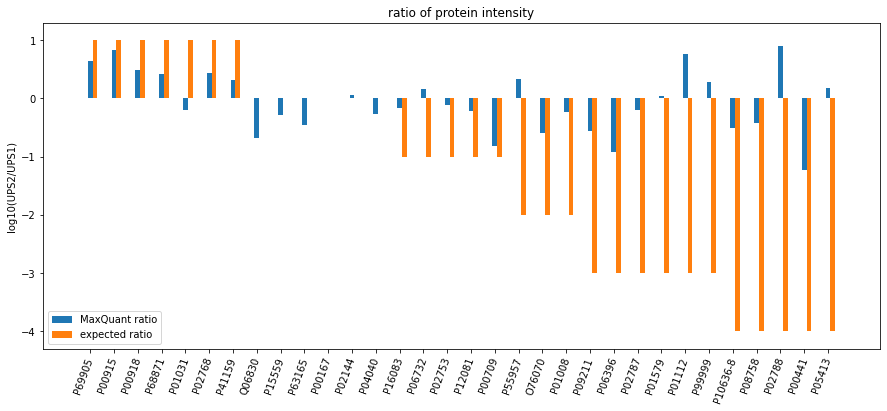

In [119]:
labels = ratios_df.protein_code
mq_ratio = np.log10(ratios_df.ratio)
expected_ratio = np.log10(ratios_df.expected_ratio)

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

f, ax = plt.subplots()
f.set_figheight(6)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

rects1 = ax.bar(x, mq_ratio, width, label='MaxQuant ratio')
rects2 = ax.bar(x + width, expected_ratio, width, label='expected ratio')

# add text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('log10(UPS2/UPS1)')
ax.set_title('ratio of protein intensity')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=70, ha='right')
ax.legend()

# create offset transform (x=5pt)
from matplotlib.transforms import ScaledTranslation
dx, dy = 5, 0
offset = ScaledTranslation(dx/f.dpi, dy/f.dpi, scale_trans=f.dpi_scale_trans)

# apply offset transform to all xticklabels
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
    
plt.show()

### how many proteins does MaxQuant find with Andromeda

In [39]:
MQ_ANALYSIS_DIR = '{}/MQ-analysis-of-P3830/combined/txt'.format(expanduser('~'))

In [40]:
mq_results_df = pd.read_csv('{}/evidence.txt'.format(MQ_ANALYSIS_DIR), sep='\\t', engine='python')

In [41]:
mq_results_df.columns

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Type',
       'Raw file', 'MS/MS m/z', 'Charge', 'm/z', 'Mass',
       'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Ion mobility index',
       'Ion mobility length', '1/K0', '1/K0 length', 'Calibrated 1/K0', 'CCS',
       'Calibrated CCS', 'CCS length', 'Match time difference',
       'Match m/z difference', 'Match K0 difference', 'Match q-value',
       'M

In [42]:
# remove decoys, which are indicated by a '+' in the Reverse column
mq_results_df = mq_results_df[pd.isna(mq_results_df.Reverse)]
# remove identifications with no intensity
mq_results_df = mq_results_df[(mq_results_df.Intensity > 0)]
# remove potential contaminants
mq_results_df = mq_results_df[pd.isna(mq_results_df['Potential contaminant'])]
# remove identifications with mass error more than +/- 5 ppm
mq_results_df = mq_results_df[np.abs(mq_results_df['Mass error [ppm]']) <= 5.0]
# remove yeast proteins
mq_results_df = mq_results_df[(~mq_results_df['Proteins'].str.contains('YEAST'))]


In [43]:
mq_results_df.sample(n=10)[['Proteins','Leading proteins']]

,Proteins,Leading proteins
144294,sp|P02788|TRFL_HUMAN,sp|P02788|TRFL_HUMAN
177768,sp|Q9P2R3|ANFY1_HUMAN,sp|Q9P2R3|ANFY1_HUMAN
123798,sp|P01375|TNFA_HUMAN,sp|P01375|TNFA_HUMAN
121668,sp|P09211|GSTP1_HUMAN,sp|P09211|GSTP1_HUMAN
59711,sp|P00915|CAH1_HUMAN,sp|P00915|CAH1_HUMAN
180193,sp|P00918|CAH2_HUMAN,sp|P00918|CAH2_HUMAN
85625,sp|P69905|HBA_HUMAN,sp|P69905|HBA_HUMAN
40769,sp|P01008|ANT3_HUMAN,sp|P01008|ANT3_HUMAN
148402,sp|P10636|TAU_HUMAN,sp|P10636|TAU_HUMAN
181236,sp|P01579|IFNG_HUMAN,sp|P01579|IFNG_HUMAN


In [44]:
# definition of uniqueness in MaxQuant output with MBR on
proteins_l = []
unique_peptide_key = ['Sequence','Modifications','Charge']
for group_name,group_df in mq_results_df.groupby(unique_peptide_key):
    protein = group_df.iloc[0]['Leading proteins']
    if len(group_df['Leading proteins'].unique()) > 1:
        print('more than one protein')
    proteins_l.append({'peptide':group_name, 'protein':protein})
mq_proteins_df = pd.DataFrame(proteins_l)

In [45]:
print('number of unique proteins: {}'.format(len(mq_proteins_df.protein.unique())))

number of unique proteins: 85
